#Context

In this day and age, there are bike sharing systems in cities all around the world. With these systems, people can register an account and rent bikes at certain checkpoints scattered around a geographical area. It's cheap, convenient and good for the environment.

Because of this developing area of urban planning and implementation, having a greater understanding of usage patterns for these services can contribute greatly to cities and society overall.

The dataset below contains information about users of bike sharing systems and the conditions of when the service is used such as temperature, weather and time of year.

In this notebook, I will conduct a full analysis of this dataset and use it to create a regression model that can accurately predict the number of people using a bike system on a given day depending on weather conditions, time of year and other useful features.

Link to the dataset: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

Regarding the creator of the dataset I will be analyzing, full credit goes to Hadi Fanaee-T, the donator of the dataset to the UCI Machine Learning Repository. Now, let's get started!

#Data Dictionary

- instant: This is an ID number and index for the row.

- dtheday: This is the exact date of the row instance containing day, month and year.

- season: This is the season of the instance. (1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall)

- yr: This is the year of the instance.

- mnth: This is the month of the instance. (month 1-12)

- hr: This is the hour of the instance. (0-23)

- holiday: This is whether or not the instance occurred on a holiday. (1 = yes, 0 = no)

- weekday: This is the day of the week of the instance. (day 1 - 7)

- workingday: This is whether or not the instance is a working day, meaning not a weekend or a holiday. 1 = yes, 0 = no)

- weathersit: This is how cloudy the instance weather is. (1 = Clear, 2 = A few clouds, 3 = Overcast)

- temp: This is the normalized instance temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale).

- ntemp: This is the normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale).

- hum: This is the normalized instance humidity. The values are divided to 100 (max).

- windspeed: This is the normalized instance wind speed. The values are divided to 67 (max).

- casual: This is the count of casual users of bike sharing services per instance.

- registered: This is the count of registered users of bike sharing services per instance.

- cnt: This is the total count of casual users and registered users per instance. It will be my target.

#Imports and Overview

In [ ]:
!pip install outlier_utils
!pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from outliers import smirnov_grubbs as grubbs
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab
import scipy.stats as stats
from scipy.stats import f_oneway
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
import warnings

In [ ]:
file = '/content/drive/MyDrive/Machine Learning Project/day.csv'
df = pd.read_csv(file)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
None
(731, 16)


In [ ]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


Observations:

The dataset is quite small, only 731 rows, but lots of features.

The most useful target feature is probably [cnt].

The [cnt] feature has a high mean and extremely varied range (min = 22, max = 8714).

#Cleaning and Preprocessing

The dataset came pretty clean, so there are only a couple of small things to tweak.

I'll drop the [dteday] right now because all of the relevant information it contains is organized elsewhere ([mnth], [yr]). I will also remove [instant], as it's only meant to serve as an index. I will remove more columns later.

In [ ]:
df = df.drop(['dteday', 'instant'], axis = 1)

In [ ]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


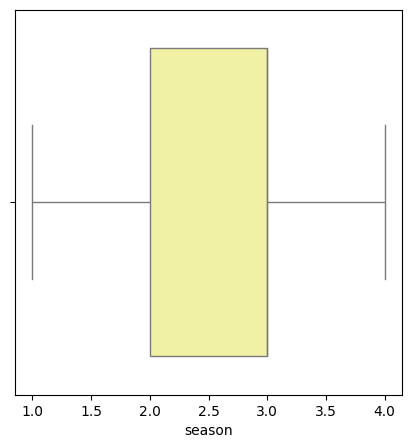

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


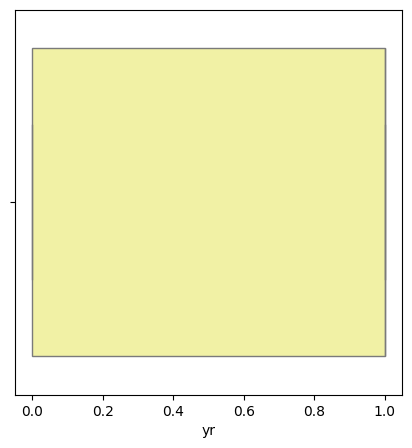

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


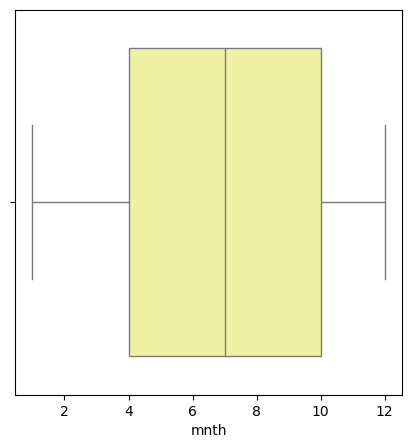

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


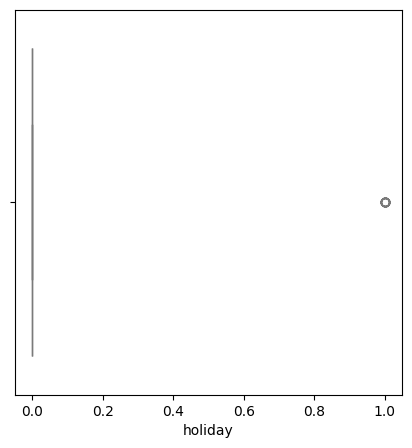

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


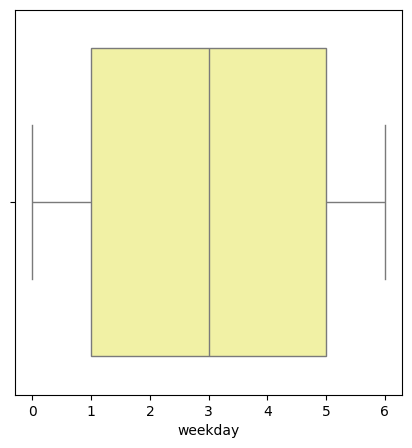

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


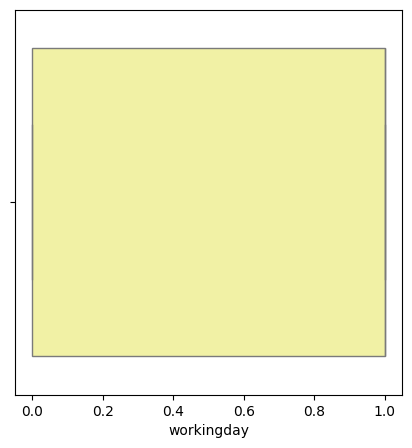

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


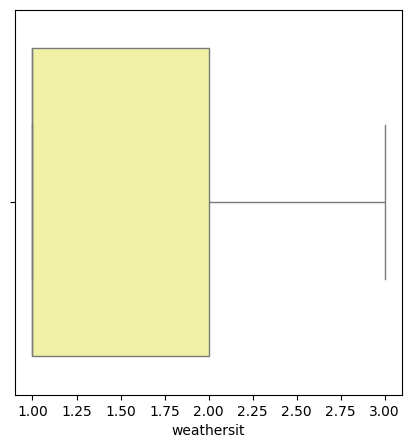

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


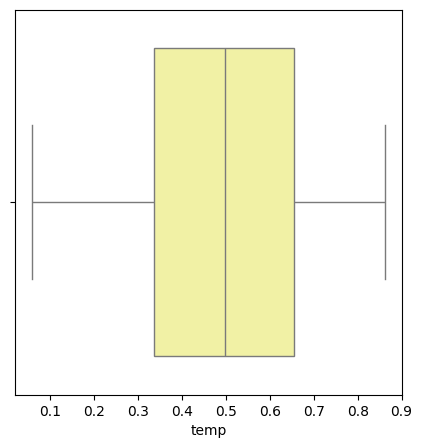

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


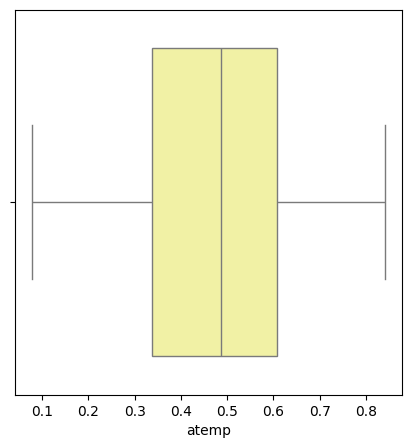

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


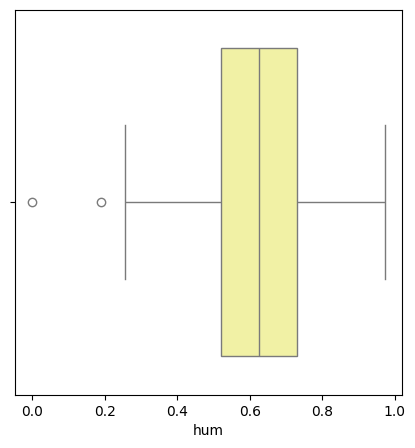

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


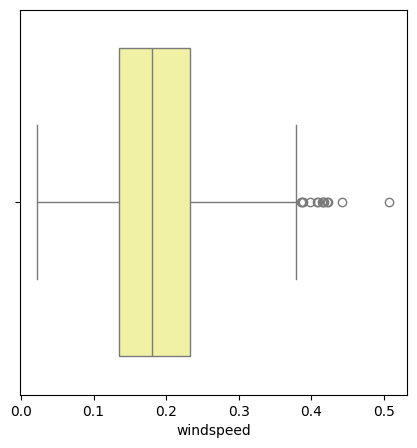

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


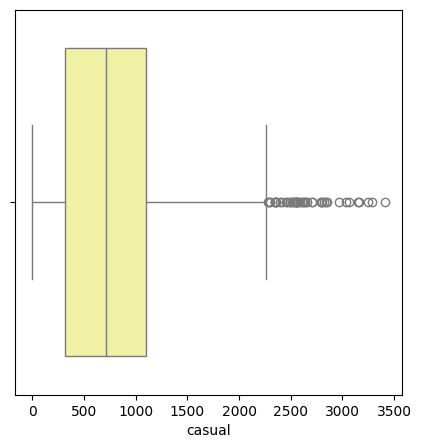

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


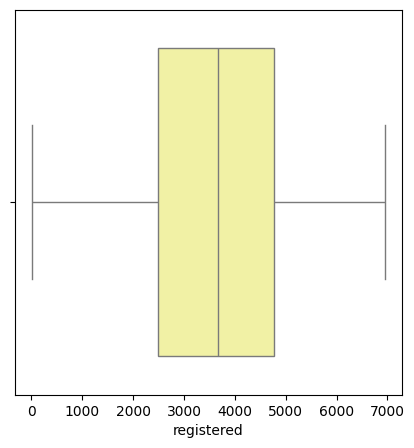

/tmp/ipython-input-8-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


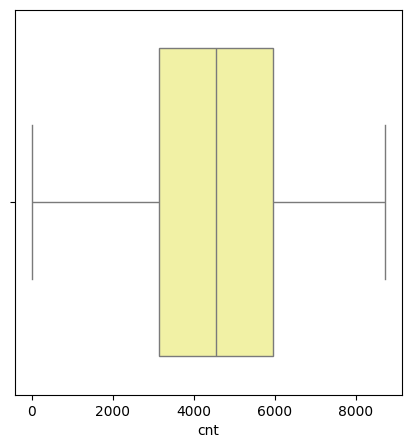

In [ ]:
numcols = df.select_dtypes(include = ['float64', 'int64'])
catcols = df.select_dtypes(include = 'object')

for i in df.columns:
  plt.figure(figsize = (5,5))
  sns.boxplot(df, x = i, palette = 'terrain')
  plt.show()

According to the boxplots above, the relevant outliers are [windspeed], [hum] and [casual].

In [ ]:
outliers = ['windspeed', 'hum', 'casual']

def IQRF(col):
	Q1 = df[col].quantile(0.25)
	Q3 = df[col].quantile(0.75)
	IQR = Q3 - Q1
	lb = Q1 - 1.5 * IQR
	ub = Q3 + 1.5 * IQR
	return (df[col] < lb) | (df[col] > ub)

for col in df[outliers]:
  df.loc[IQRF(col), col] = np.nan

print(df[outliers].isna().sum())

windspeed    13
hum           2
casual       44
dtype: int64


In [ ]:
wmean = df['windspeed'].mean()
hmean = df['hum'].mean()
cmean = df['casual'].mean()

wmedian = df['windspeed'].median()
hmedian = df['hum'].median()
cmedian = df['casual'].median()

print(f'The means are: {wmean}, {hmean} and {cmean}')
print(f'The medians are: {wmedian}, {hmedian} and {cmedian}')

The means are: 0.18639180459610027, 0.6293589067215364 and 732.0101892285298
The medians are: 0.178802, 0.6275 and 674.0


For [windspeed] and [hum], I will fill the outliers with the mean. However, for [casual], I will use the median since there is a significant difference between the mean and the median in this feature, which would affect the overall distribution.

In [ ]:
df['windspeed'] = df['windspeed'].fillna(df['windspeed'].mean())
df['hum'] = df['hum'].fillna(df['hum'].mean())
df['casual'] = df['casual'].fillna(df['casual'].median())

I will drop [holiday] because it has been deemed irrelevant in previous model attempts. I will also drop [casual] and [registered] because they are directly related to the target (they are combined to calculated [cnt]).

In [ ]:
df = df.drop(['holiday', 'casual', 'registered'], axis = 1)

#Model 1: Random Forest Regression

In [ ]:
df.head()

,season,yr,mnth,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


The target column [cnt] has no outliers, but it is incredibly varied. This has been causing the RMSEs in the predictions of previous models to be very different, undermining the results. To remedy this, I will train the model on standardized data (I will not use log because there aren't any outliers), and then change it back to normal for metric evaluation. This will hopefull decrease difference in RMSE.

In [ ]:
y = df['cnt']
X = df.drop(['cnt'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler_X = StandardScaler()
x_train_scaled = scaler_X.fit_transform(x_train)
x_test_scaled = scaler_X.transform(x_test)

y_mean = y_train.mean()
y_std = y_train.std()
y_train_std = (y_train - y_mean) / y_std
y_test_std = (y_test - y_mean) / y_std

In [ ]:
lr = LinearRegression()
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()
ridge = Ridge()
lasso = Lasso()

models = [lr, dtr, rfr, ridge, lasso]
model_name = ['LinearRegression',
              'DecisionTreeRegressor',
              'RandomForestRegressor',
              'Ridge',
              'Lasso'
              ]

average_rmse = []
average_r2_score = []
for model, name in zip(models, model_name):
  scores = ['neg_root_mean_squared_error', 'r2']
  cv_score_rmse = cross_val_score(model, x_train_scaled, y_train_std, cv = 5, scoring = 'neg_root_mean_squared_error')
  cv_score_r2 = cross_val_score(model, x_train_scaled, y_train_std, cv = 5, scoring = 'r2')
  average_rmse.append(np.mean(-1 * cv_score_rmse))
  average_r2_score.append(np.mean(cv_score_r2))
  print('RMSE scores of {} are {}'.format(name, -1 * cv_score_rmse))
  print("R2 scores of {} are {}".format(name, cv_score_r2))
  print('-' * 100)

RMSE scores of LinearRegression are [0.49718341 0.41957673 0.51092551 0.5369626  0.40848244]
R2 scores of LinearRegression are [0.75653252 0.81014308 0.76503914 0.6511951  0.8364649 ]
----------------------------------------------------------------------------------------------------
RMSE scores of DecisionTreeRegressor are [0.45280434 0.59239735 0.56829554 0.51533025 0.46685499]
R2 scores of DecisionTreeRegressor are [0.80741196 0.68994858 0.73791525 0.65126404 0.79033181]
----------------------------------------------------------------------------------------------------
RMSE scores of RandomForestRegressor are [0.30713892 0.37591313 0.45304011 0.40390051 0.31706378]
R2 scores of RandomForestRegressor are [0.90279485 0.84523715 0.82225569 0.80584418 0.89856466]
----------------------------------------------------------------------------------------------------
RMSE scores of Ridge are [0.47584919 0.41934798 0.51097446 0.53665048 0.40876029]
R2 scores of Ridge are [0.77697868 0.810350

/tmp/ipython-input-16-1980373357.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = model_name, y=average_rmse, palette = 'terrain')


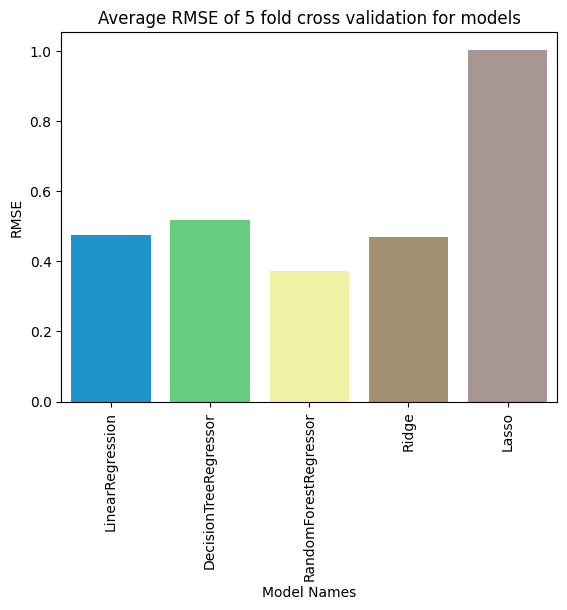

In [ ]:
sns.barplot(x = model_name, y=average_rmse, palette = 'terrain')
plt.title("Average RMSE of 5 fold cross validation for models")
plt.xticks(rotation = 90)
plt.xlabel("Model Names")
plt.ylabel("RMSE")
plt.show()

/tmp/ipython-input-17-532314237.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = model_name, y = average_r2_score, palette = 'terrain')


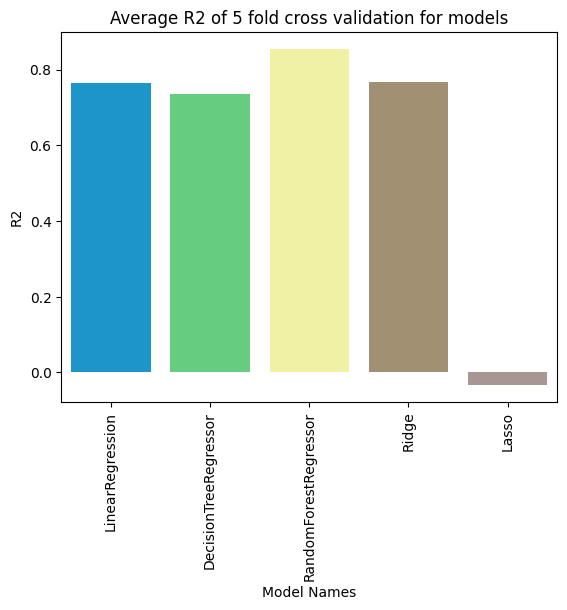

In [ ]:
sns.barplot(x = model_name, y = average_r2_score, palette = 'terrain')
plt.title("Average R2 of 5 fold cross validation for models")
plt.xticks(rotation=90)
plt.xlabel("Model Names")
plt.ylabel("R2")
plt.show()

Since Random Forest Regressor has the highest r score and the lowest RMSE, I'll try it first. Before implementing hyperparameters, I will first check feature importance to ensure there are no overpowering features or secret linear relationships with the target feature.

In [ ]:
rfr = RandomForestRegressor()
model = rfr.fit(x_train_scaled, y_train_std)

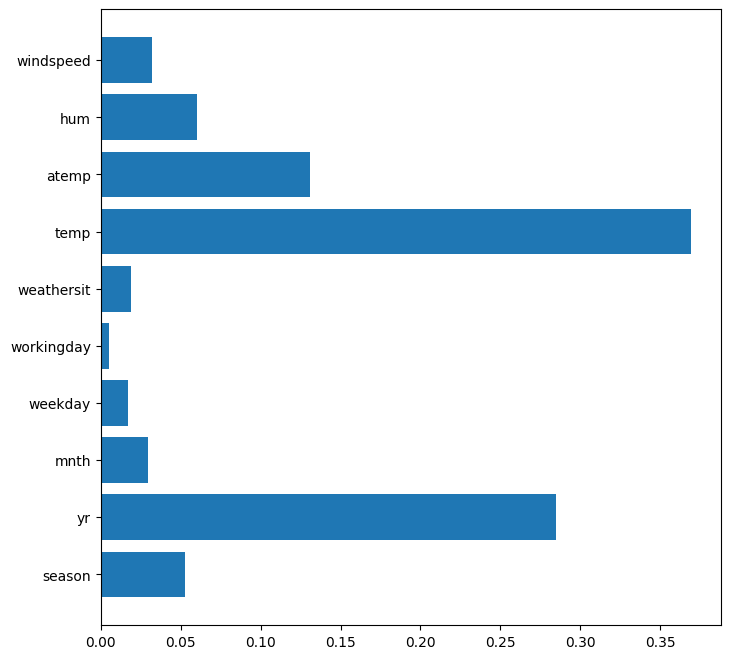

In [ ]:
importance = model.feature_importances_
xcols = X.columns

plt.figure(figsize = (8, 8))
plt.barh(xcols, importance)
plt.show()

Observation:

- Some features ([yr] and [temp]) are stronger than others ([workingday], [weekday] and [weathersit]), but the distribution is balanced enough to be acceptable.

In [ ]:
params = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'oob_score': [True, False]}

rfr = RandomForestRegressor(random_state = 42)

grid = GridSearchCV(
    estimator = rfr,
    param_grid = params,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1)


grid.fit(x_train_scaled, y_train_std)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300],
                         'oob_score': [True, False]},
             scoring='neg_mean_squared_error')

To ensure proper replicability of best parameters, I set the random state of the regressor and repeated the grid search 3 times. Each yielded the same hyperparameters, ensuring the correct settings for this model.

In [ ]:
print("Tuned Random Forest Regressor Parameters: ", grid.best_params_,'.')
print("Best score is ", -1 * grid.best_score_,'.')

Tuned Random Forest Regressor Parameters:  {'max_features': 'sqrt', 'n_estimators': 300, 'oob_score': True} .
Best score is  0.12637955947610294 .


In [ ]:
rfr_final = RandomForestRegressor(max_features='sqrt',
                                  n_estimators=300,
                                  oob_score=True)

rfr_final.fit(x_train_scaled, y_train_std)

RandomForestRegressor(max_features='sqrt', n_estimators=300, oob_score=True)

In [ ]:
yhat_test_std = rfr_final.predict(x_test_scaled)
print(yhat_test_std[:7])

[ 0.92436004 -1.5677519  -0.65559921  0.06444497  1.53130447  1.42534891
 -1.6225466 ]


In [ ]:
yhat_train_std = rfr_final.predict(x_train_scaled)
print(yhat_train_std[:7])

[-0.13068506 -1.17757706 -0.49468195 -0.06484966  1.39317311 -0.25707297
 -0.08146202]


Now that I have made training and testing predictions with the standardized data, I will check scoring with the actual data.

In [ ]:
yhat_test_orig = yhat_test_std * y_std + y_mean
yhat_train_orig = yhat_train_std * y_std + y_mean

In [ ]:
testr2 = metrics.r2_score(y_test, yhat_test_orig)
print(testr2)

testrmse = metrics.root_mean_squared_error(y_test, yhat_test_orig)
print(testrmse / y_test.mean())

testmse = metrics.mean_squared_error(y_test, yhat_test_orig)
print(testmse)

0.8815218729201816
0.16106628550741736
475083.34336190444


In [ ]:
xtestr2 = metrics.r2_score(y_train, yhat_train_orig)
print(xtestr2)

xtestrmse = metrics.root_mean_squared_error(y_train, yhat_train_orig)
print(xtestrmse / y_train.mean())

xtestmse = metrics.mean_squared_error(y_train, yhat_train_orig)
print(xtestmse)

0.9836641667719568
0.05365265828006544
59882.28917089033


Unfortunately, even when using the transformed data, the RMSEs are still very different. This can undermine the integrity of the model.

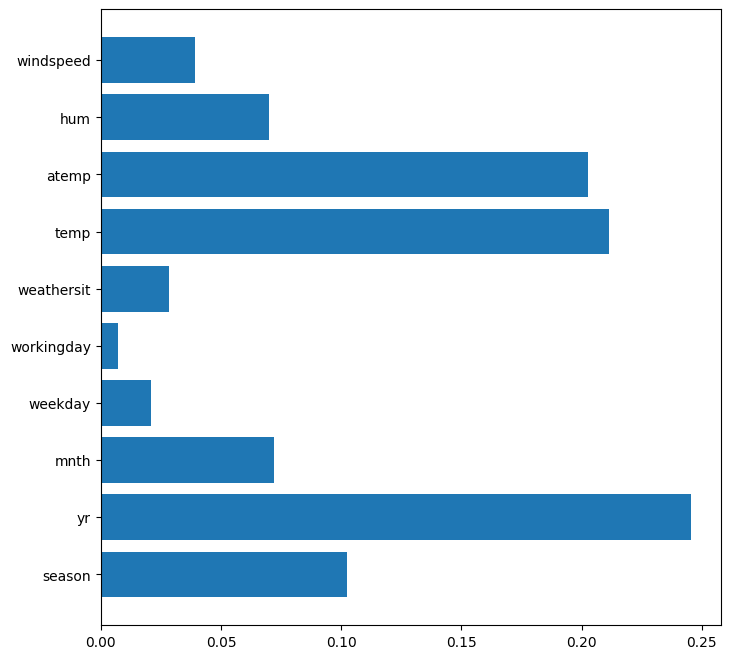

In [ ]:
importance = rfr_final.feature_importances_
xcols = X.columns

plt.figure(figsize = (8, 8))
plt.barh(xcols, importance)
plt.show()

After implementing hyperparameters, the feature importances are a bit more balanced than before.

In [ ]:
common_rows = pd.merge(x_test, x_train).drop_duplicates()

print("Matching rows between x_test and x_train:")
print(common_rows)

Matching rows between x_test and x_train:
Empty DataFrame
Columns: [season, yr, mnth, weekday, workingday, weathersit, temp, atemp, hum, windspeed]
Index: []


There doesn't appear to be any matching rows, so the issue with RMSE isn't being caused by leakage either.

Since Random Forest Regressor continues running into the same problems regarding its RMSE, I will instead try Linear Regression. It also scored well, and it is a simpler model, so it may give better overall performance.

#Model 2: Linear Regression

##Assumption 1: Independence

This assumption was met when I removed [casual] and [registered] from the dataset. Nothing in X has a direct relationship with y.

##Assumption 2: Multicollinearity

For linear regression, I will not be scaling the features like I did in Random Forest Regression, to see if the RMSEs are having similar issues.

In [ ]:
df.head()

,season,yr,mnth,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [ ]:
y = df['cnt']
X = df.drop(['cnt'], axis = 1)
X = sm.add_constant(X)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
lr = sm.OLS(y_train, x_train)
model = lr.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     213.2
Date:                Thu, 03 Jul 2025   Prob (F-statistic):          8.52e-186
Time:                        09:10:16   Log-Likelihood:                -4788.9
No. Observations:                 584   AIC:                             9600.
Df Residuals:                     573   BIC:                             9648.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1088.1666    274.300      3.967      0.0

In [ ]:
def check_vif(predictors):
  vif = pd.DataFrame()
  vif['feature'] = predictors.columns

  vif['VIF'] = [
      variance_inflation_factor(predictors.values, i)
      for i in range(len(predictors.columns))
  ]

  vif = vif.sort_values(by = 'VIF', ascending = False)

  return vif

In [ ]:
check_vif(x_train)

,feature,VIF
0,const,55.529009
8,atemp,54.569892
7,temp,53.733857
1,season,3.883030
3,mnth,3.688302
9,hum,2.028258
6,weathersit,1.881828
10,windspeed,1.185882
2,yr,1.027873
5,workingday,1.018667


I hypothesize that [temp] and [atemp] are causing multicollinearity in each other. The same goes for [season] and [mnth]. Once I remove one, the other will most likely correct itself.

In [ ]:
def treat_multic(features, target, high_vif_columns, score):
  adj_r2 = []
  rmse = []

  for cols in high_vif_columns:
    train = features.loc[:, ~features.columns.str.startswith(cols)]
    modelz = sm.OLS(target, train).fit()
    adj_r2.append(modelz.rsquared_adj)
    rmse.append(np.sqrt(modelz.mse_resid))

  temp = pd.DataFrame({
      'col': high_vif_columns,
      'Adj. R-squared': adj_r2,
      'RMSE':rmse,
      }
  ).sort_values(by = 'Adj. R-squared', ascending = False)
  temp.reset_index(drop = True, inplace = True)
  temp['difference'] = temp['Adj. R-squared'] - score

  return temp

In [ ]:
cols = ['atemp', 'temp', 'season', 'mnth']

res = treat_multic(x_train, y_train, cols, 0.788)
res

,col,Adj. R-squared,RMSE,difference
0,temp,0.784383,889.799446,-0.006617
1,mnth,0.783449,891.725686,-0.007551
2,atemp,0.782776,893.110254,-0.008224
3,season,0.759896,938.967053,-0.031104


I will remove [temp] and [mnth], as they seem to have less of an impact on the model.

In [ ]:
x_train2 = x_train.drop(['temp', 'mnth'], axis = 1)
lr2 = sm.OLS(y_train, x_train2)
model2 = lr2.fit()
print(
    "R-squared:",
    np.round(model2.rsquared, 3),
    "\nAdjusted R-squared:",
    np.round(model2.rsquared_adj, 3),
)

R-squared: 0.786 
Adjusted R-squared: 0.783


In [ ]:
check_vif(x_train2)

,feature,VIF
0,const,52.511390
7,hum,2.002045
5,weathersit,1.879001
6,atemp,1.229353
1,season,1.190081
8,windspeed,1.153530
2,yr,1.026359
4,workingday,1.017407
3,weekday,1.011497


It seems I was correct (Yay~). Multicollinearity has been removed from the model.

##Assumption 3: Linearity

In [ ]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     264.5
Date:                Thu, 03 Jul 2025   Prob (F-statistic):          3.98e-187
Time:                        09:10:16   Log-Likelihood:                -4791.5
No. Observations:                 584   AIC:                             9601.
Df Residuals:                     575   BIC:                             9640.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1028.6865    267.455      3.846      0.0

In [ ]:
x_train3 = x_train2
lr3 = sm.OLS(y_train, x_train3)
model3 = lr3.fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     264.5
Date:                Thu, 03 Jul 2025   Prob (F-statistic):          3.98e-187
Time:                        09:10:16   Log-Likelihood:                -4791.5
No. Observations:                 584   AIC:                             9601.
Df Residuals:                     575   BIC:                             9640.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1028.6865    267.455      3.846      0.0

##Assumption 4: Homoscedasticity

In [ ]:
df_res = pd.DataFrame()
df_res['Actual Values'] = y_train.values.flatten()
df_res['Fitted_Values'] = model3.fittedvalues.values
df_res['Residuals'] = model3.resid.values

df_res.head()

,Actual Values,Fitted_Values,Residuals
0,4094,4596.035722,-502.035722
1,1842,3041.860484,-1199.860484
2,3614,3677.768681,-63.768681
3,4274,3643.722682,630.277318
4,7335,7158.584793,176.415207


In [ ]:
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(df_res["Residuals"], x_train3)
lzip(name, test)

[('F statistic', np.float64(1.057875143838595)),
 ('p-value', np.float64(0.3181813976980275))]

The data appears to be homosecdastic.

##Assumption 5: Normality:

In [ ]:
df_res = pd.DataFrame()
df_res['Actual Values'] = y_train_std.values.flatten()
df_res['Fitted_Values'] = model3.fittedvalues.values
df_res['Residuals'] = model3.resid.values

df_res.head()

,Actual Values,Fitted_Values,Residuals
0,-0.243694,4596.035722,-502.035722
1,-1.418910,3041.860484,-1199.860484
2,-0.494184,3677.768681,-63.768681
3,-0.149761,3643.722682,630.277318
4,1.447636,7158.584793,176.415207


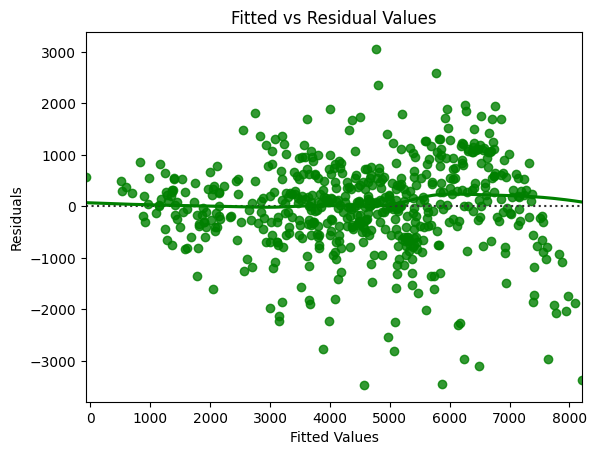

In [ ]:
sns.residplot(data = df_res, x = 'Fitted_Values', y = 'Residuals', color = 'green', lowess = True)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Fitted vs Residual Values')
plt.show()

In [ ]:
x_train3.columns

Index(['const', 'season', 'yr', 'weekday', 'workingday', 'weathersit', 'atemp',
       'hum', 'windspeed'],
      dtype='object')

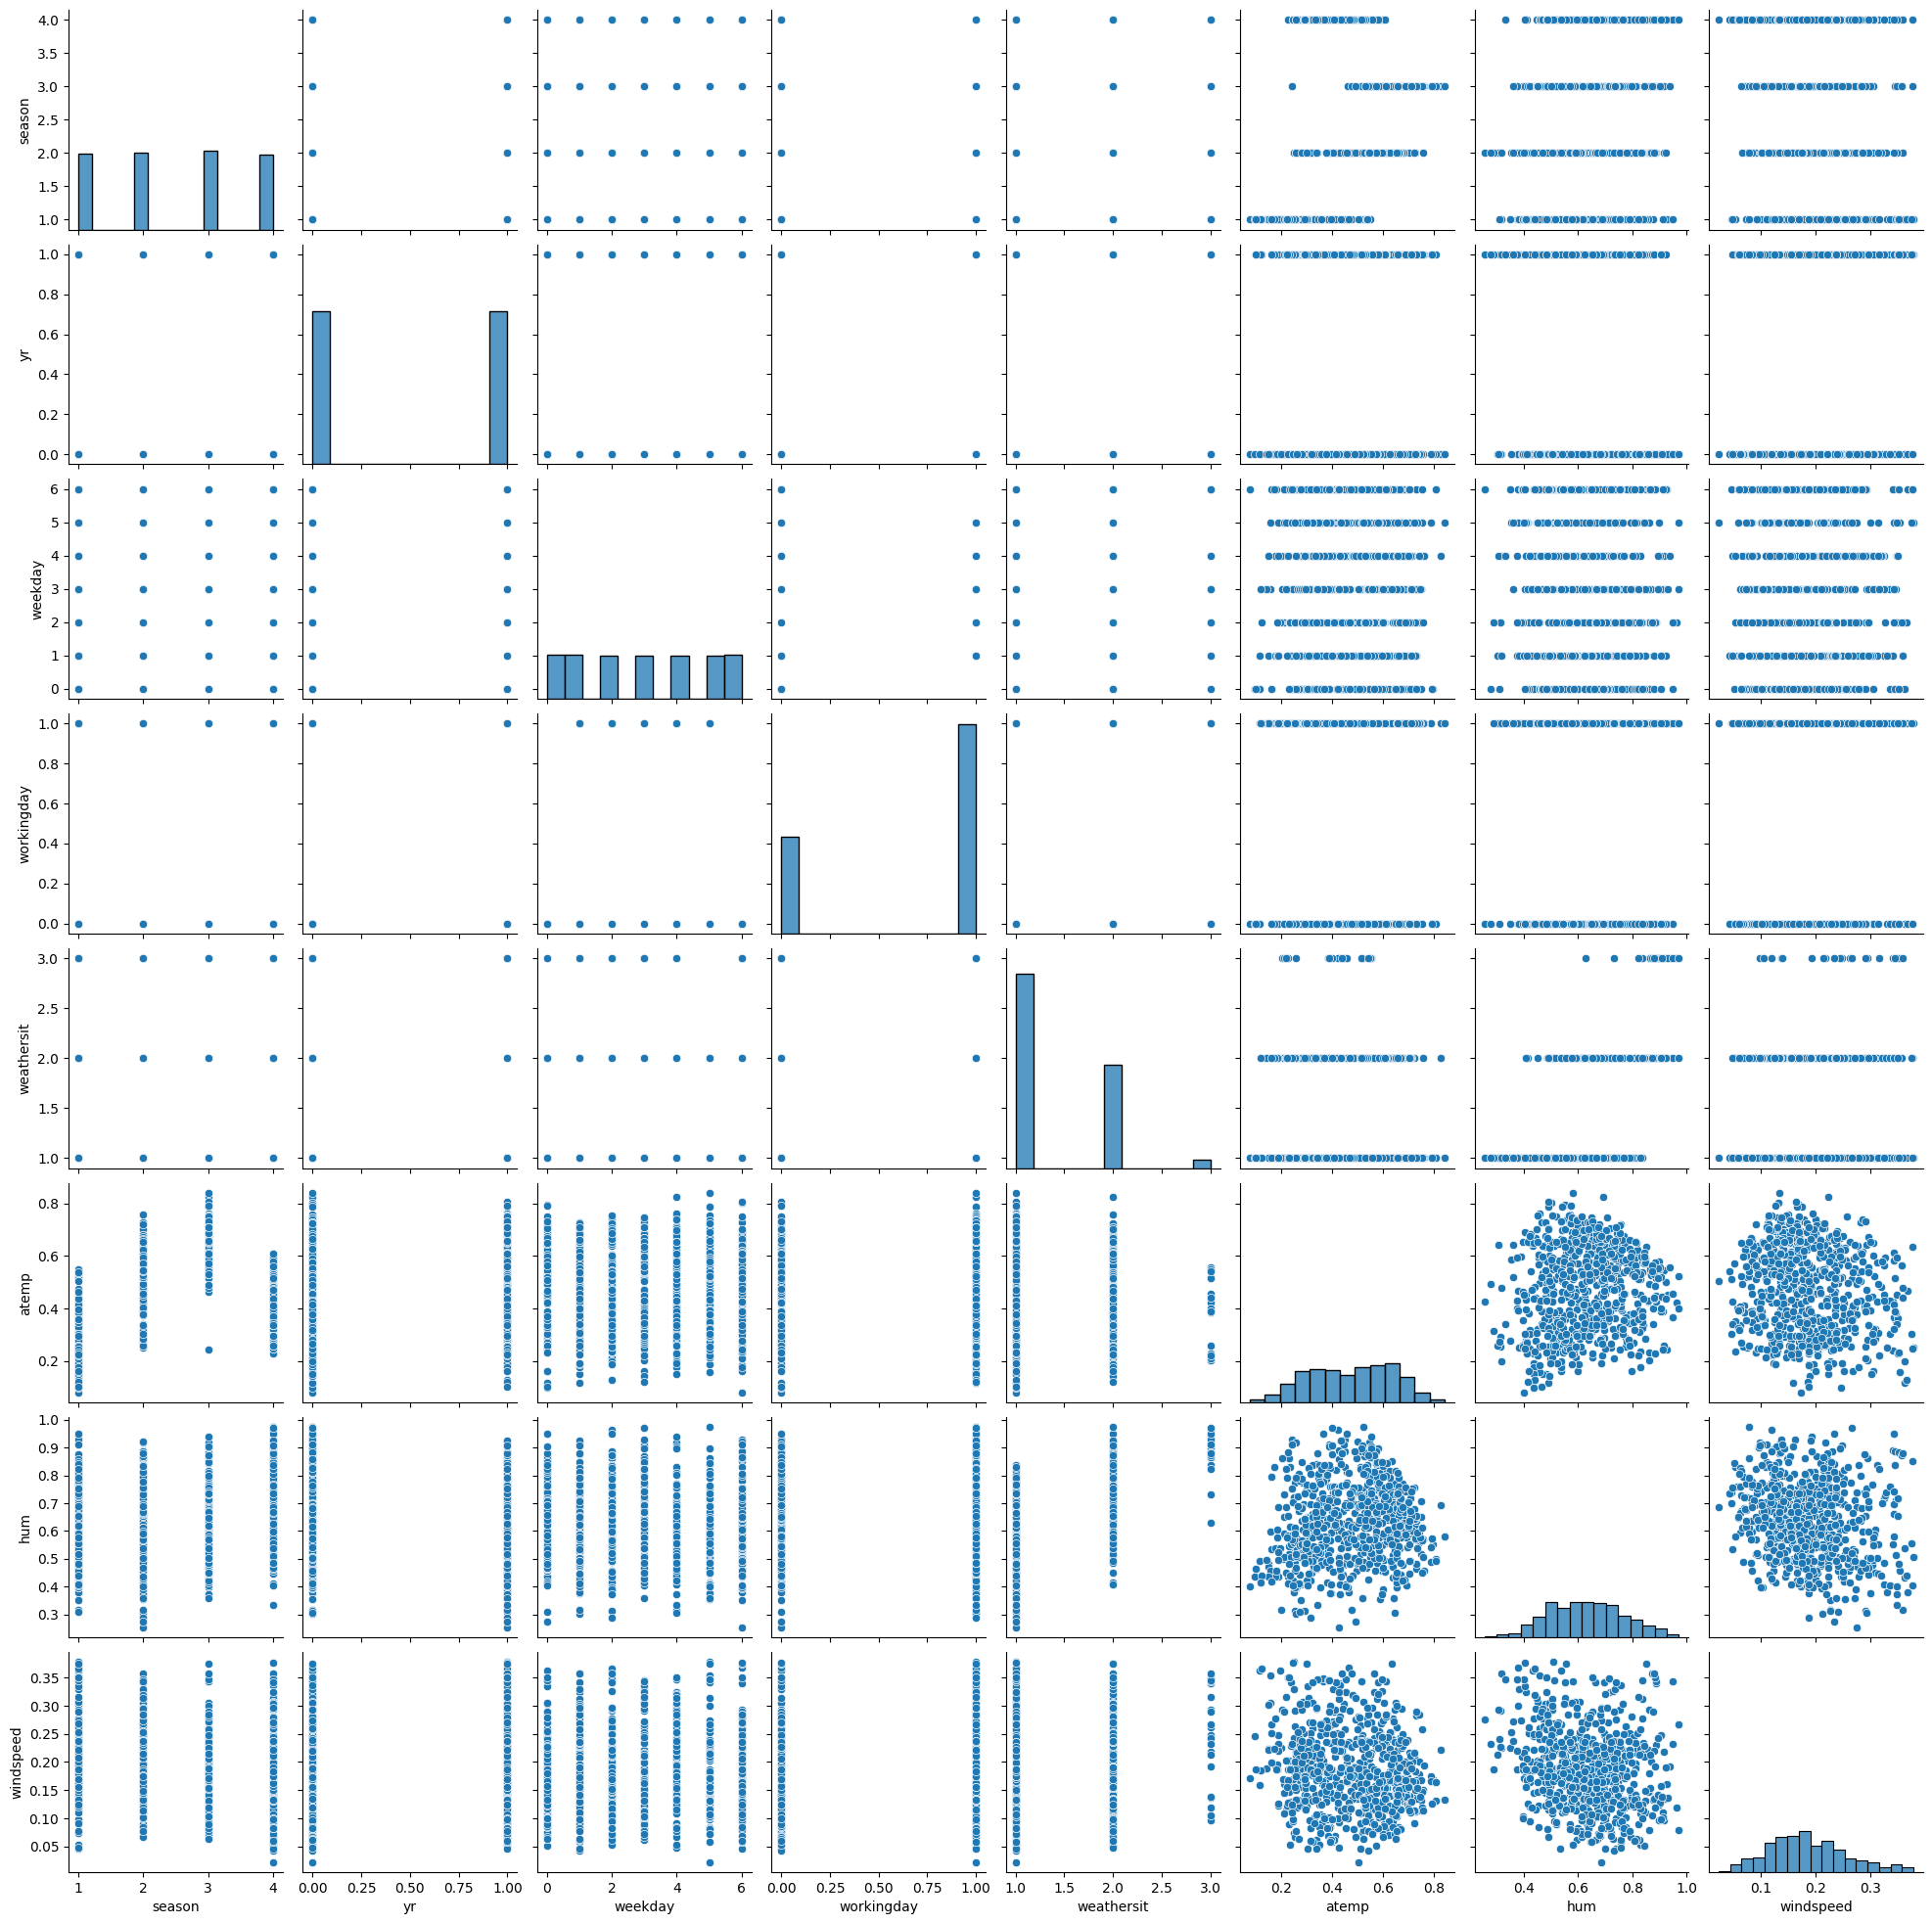

In [ ]:
sns.pairplot(df[['season', 'yr', 'weekday', 'workingday', 'weathersit', 'atemp',
       'hum', 'windspeed']])
plt.show()

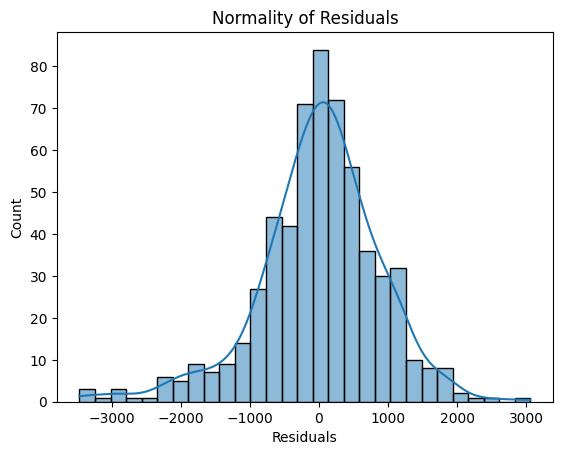

In [ ]:
sns.histplot(df_res['Residuals'], kde = True)
plt.title('Normality of Residuals')
plt.show()

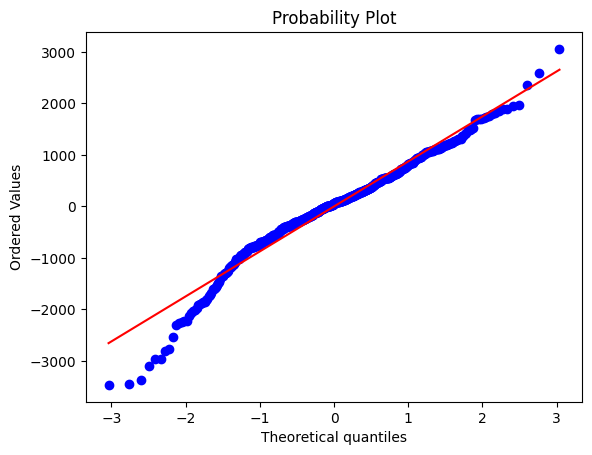

In [ ]:
stats.probplot(df_res['Residuals'], dist = 'norm', plot = pylab)
plt.show()

In [ ]:
stats.shapiro(df_res['Residuals'])

ShapiroResult(statistic=np.float64(0.9670892815104118), pvalue=np.float64(3.6607489281544164e-10))

Note:

Due to the size of the sample, the Shapiro Test P-Value is not critical.

In [ ]:
x_test = x_test.drop(['mnth', 'atemp'], axis = 1)

In [ ]:
yhat_test = model3.predict(x_test)
print(yhat_test[:7])

703    6315.428181
33     1578.665195
300    3118.338453
456    4256.287443
633    6819.609324
557    7530.675558
39      665.916421
dtype: float64


In [ ]:
yhat_train = model3.predict(x_train3)
print(yhat_train[:7])

682    4596.035722
250    3041.860484
336    3677.768681
260    3643.722682
543    7158.584793
136    2936.088166
215    4479.138546
dtype: float64


In [ ]:
testr2 = metrics.r2_score(y_test, yhat_test)
print(testr2)

testrmse = metrics.root_mean_squared_error(y_test, yhat_test)
print(testrmse / y_test.mean())

testmse = metrics.mean_squared_error(y_test, yhat_test)
print(testmse)

0.8044273326141638
0.20693770703683956
784223.375081489


In [ ]:
trainr2 = metrics.r2_score(y_train, yhat_train)
print(trainr2)

trainrmse = metrics.root_mean_squared_error(y_train, yhat_train)
print(trainrmse / y_train.mean())

trainmse = metrics.mean_squared_error(y_train, yhat_train)
print(trainmse)

0.7863230666122869
0.19404364321509296
783275.8657395287


In the final scores for linear regression, the rscore is nearly 80%, and the RMSEs are low and relatively close across training and testing scores. There is no leakage and no overpowering features. This linear regression model is functional and ready for production.